# 3章: 組合せのあるテスト: 要素に分解して考える

必要なモジュールの読み込み

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from cmdstanpy import CmdStanModel
import arviz as az

az.style.use("arviz-darkgrid")
np.random.seed(0)

script_dir = os.path.dirname('chapter3.ipynb')

## チャーリーのレポート

クリック率 $\theta$ のサンプルの軌跡

00:09:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

00:09:35 - cmdstanpy - INFO - CmdStan done processing.



Processing csv files: /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmpgbevb44v/modelmbmgfggt/model-20230403000935_1.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmpgbevb44v/modelmbmgfggt/model-20230403000935_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

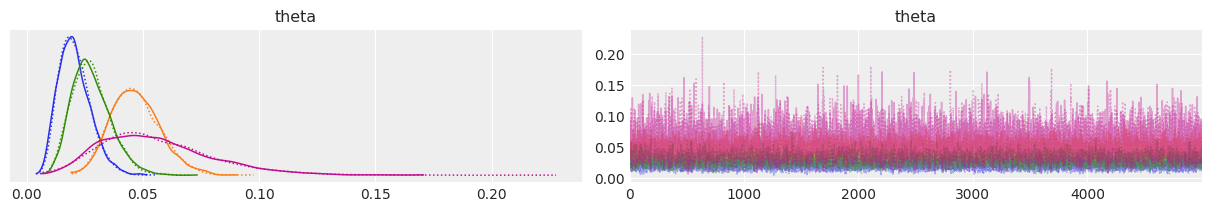

In [2]:
n = [434, 382, 394, 88]
clicks = [8, 17, 10, 4]

file_path = os.path.join(script_dir, 'model.stan')
model = CmdStanModel(stan_file=file_path)

data = {'N': len(n), 'n': n, 'clicks': clicks}

fit = model.sample(
  data=data,
  chains=2,
  seed=0,
  iter_warmup=1000,
  iter_sampling=5000,
  show_progress=True
)

cmdstanpy_data = az.from_cmdstanpy(
    posterior=fit,
    log_likelihood="lp__",
)

print(fit.diagnose())
az.plot_trace(cmdstanpy_data.posterior, compact=True) # 事後分布からのサンプルの可視化

In [3]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-188.103000,0.019714,1.432060,-190.935000,-187.764000,-186.433000,5276.69,36391.0,1.000140
theta[1],0.020656,0.000065,0.006854,0.010816,0.019934,0.033073,11260.60,77659.5,0.999977
theta[2],0.046815,0.000101,0.010598,0.030668,0.046163,0.065453,11014.90,75964.7,1.000030
theta[3],0.027782,0.000083,0.008353,0.015643,0.026943,0.042791,10184.70,70239.2,0.999848
theta[4],0.055617,0.000232,0.024142,0.022960,0.052064,0.100322,10866.00,74938.2,0.999879


確率変数 $\theta$ の事後分布の95% HDIの比較

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

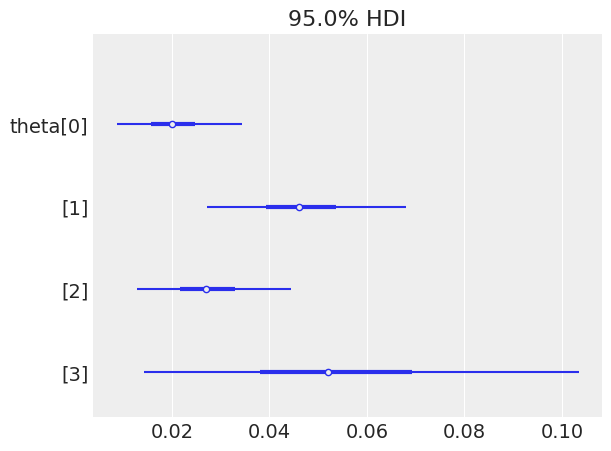

In [4]:
az.plot_forest(cmdstanpy_data.posterior, combined=True, hdi_prob=0.95)

A案とB案のクリック率の差が正となる割合

In [5]:
theta_samples = fit.stan_variable('theta')

print((theta_samples[:, 1] - theta_samples[:, 0] > 0).mean())

0.9857


A案とD案のクリック率の差が正となる割合

In [6]:
print((theta_samples[:, 3] - theta_samples[:, 0] > 0).mean())

0.9504


## 効果に着目したモデリング

ロジスティック関数

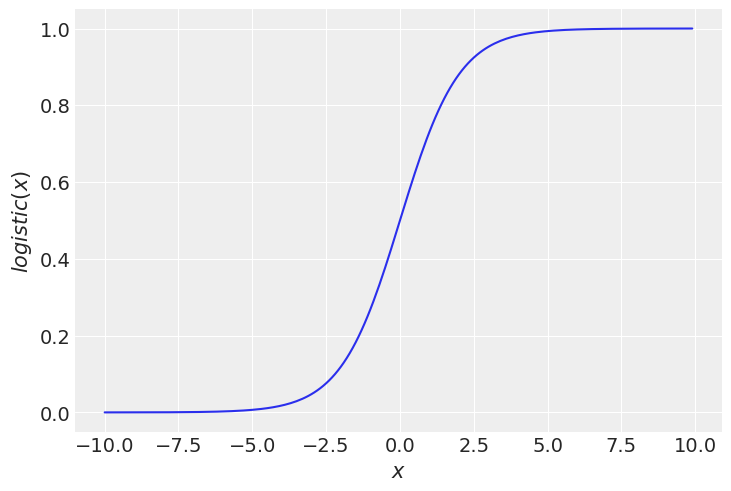

In [7]:
xs = np.arange(-10, 10, 0.1)
plt.plot(xs, 1 / (1 + np.exp(-xs)))
plt.xlabel(r'$x$')
plt.ylabel(r'$logistic(x)$')
plt.show()

さまざまな正規分布の例

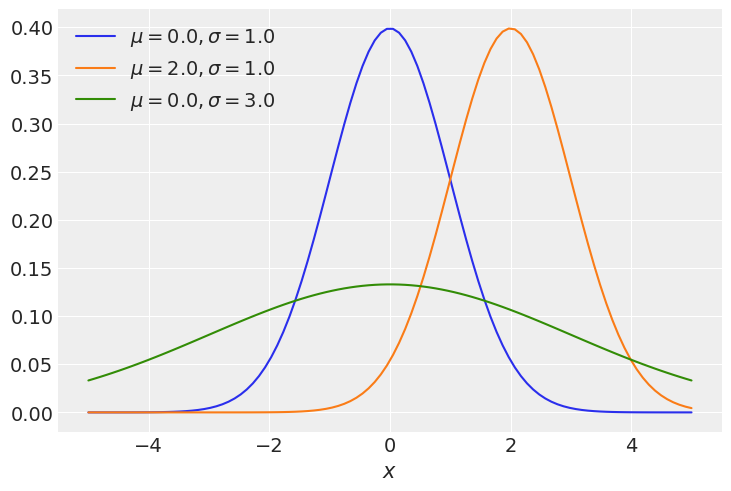

In [8]:
from scipy import stats
x = np.linspace(-5, 5, 100)
params = [(0, 1), (2, 1), (0, 3)]
for mu, sigma in params:
  plt.plot(x, stats.norm.pdf(x, mu, sigma),
      label=r'$\mu=%.1f, \sigma=%.1f$' % (mu, sigma))
plt.legend()
plt.xlabel(r'$x$')
plt.show()

## 統計モデルを書き直す

00:09:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

00:09:36 - cmdstanpy - INFO - CmdStan done processing.



Processing csv files: /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmpgbevb44v/model_combzzmosfds/model_comb-20230403000936_1.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmpgbevb44v/model_combzzmosfds/model_comb-20230403000936_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

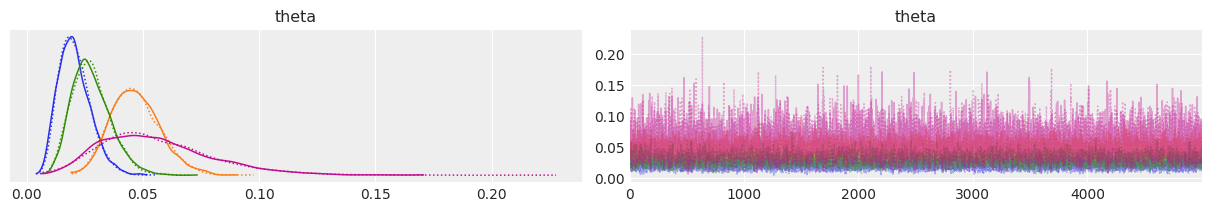

In [9]:
img = [0, 0, 1, 1]
btn = [0, 1, 0, 1]

file_path = os.path.join(script_dir, 'model_comb.stan')
model = CmdStanModel(stan_file=file_path)

data = {'N': len(n),'n': n, 'clicks': clicks , 'img': img, 'btn': btn}

fit = model.sample(
  data=data,
  chains=2,
  seed=0,
  iter_warmup=1000,
  iter_sampling=5000,
  show_progress=True
)

cmdstanpy_data_comb = az.from_cmdstanpy(
    posterior=fit,
    log_likelihood="lp__",
)

print(fit.diagnose())
az.plot_trace(cmdstanpy_data.posterior, compact=True) # 事後分布からのサンプルの可視化

$\beta$ の事後分布の可視化

array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>], dtype=object)

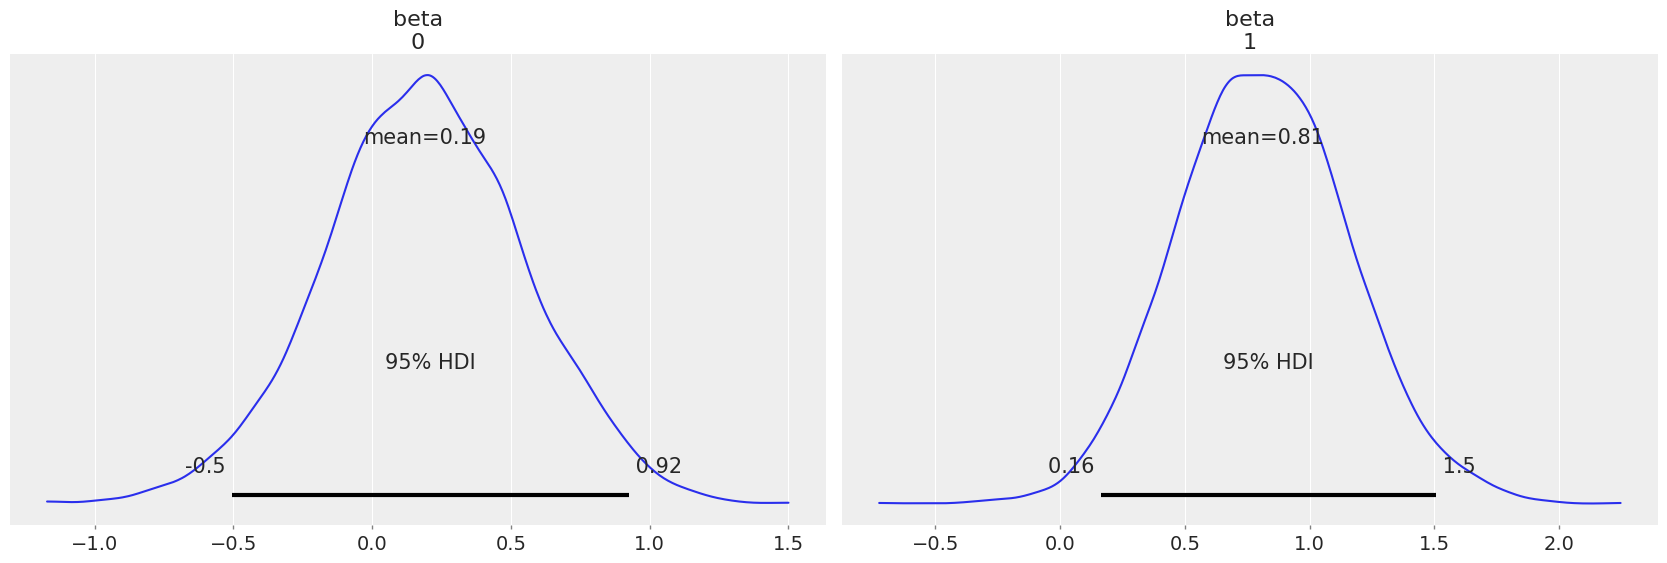

In [10]:
az.plot_posterior(cmdstanpy_data_comb.posterior.beta,hdi_prob=0.95) # 事後分布の可視化

In [11]:
beta_samples = fit.stan_variable('beta')

print((beta_samples[:, 1] > 0).mean())

0.9925


   クリック率 $\theta$ がデザイン案ごとに独立したモデル（Individual）と、
   施策効果によって接続されたモデル（Combined）それぞれについて得られた事後分布の95% HDIの比較

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

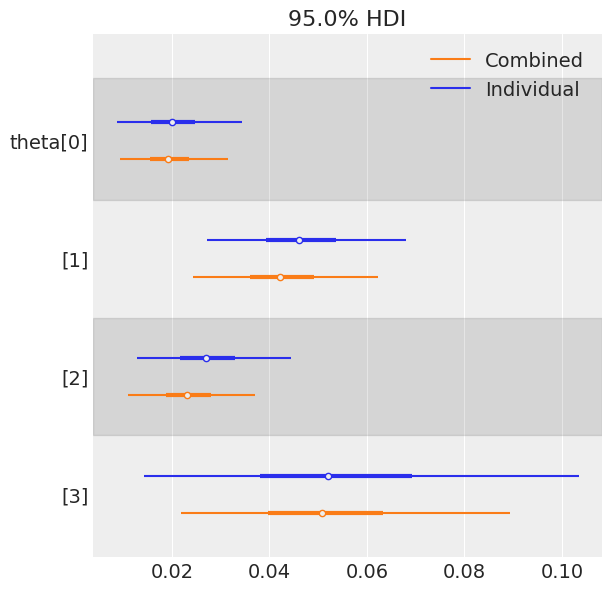

In [12]:
az.plot_forest([cmdstanpy_data.posterior.theta, cmdstanpy_data_comb.posterior.theta], combined=True, hdi_prob=0.95, model_names=['Individual', 'Combined'])

In [13]:
theta_samples = fit.stan_variable('theta')

print((theta_samples[:, 1] - theta_samples[:, 0] > 0).mean()) # 以前の値は0.9857
print((theta_samples[:, 3] - theta_samples[:, 0] > 0).mean()) # 以前の値は0.9504

0.9925
0.9606


## 完成したレポート、間違ったモデル

完成したレポートに、同じ統計モデルをあてはめたときのサンプルの軌跡

00:09:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:09:38 - cmdstanpy - INFO - CmdStan done processing.



Processing csv files: /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmpgbevb44v/model_combzbtqpwjw/model_comb-20230403000938_1.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmpgbevb44v/model_combzbtqpwjw/model_comb-20230403000938_2.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmpgbevb44v/model_combzbtqpwjw/model_comb-20230403000938_3.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmpgbevb44v/model_combzbtqpwjw/model_comb-20230403000938_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

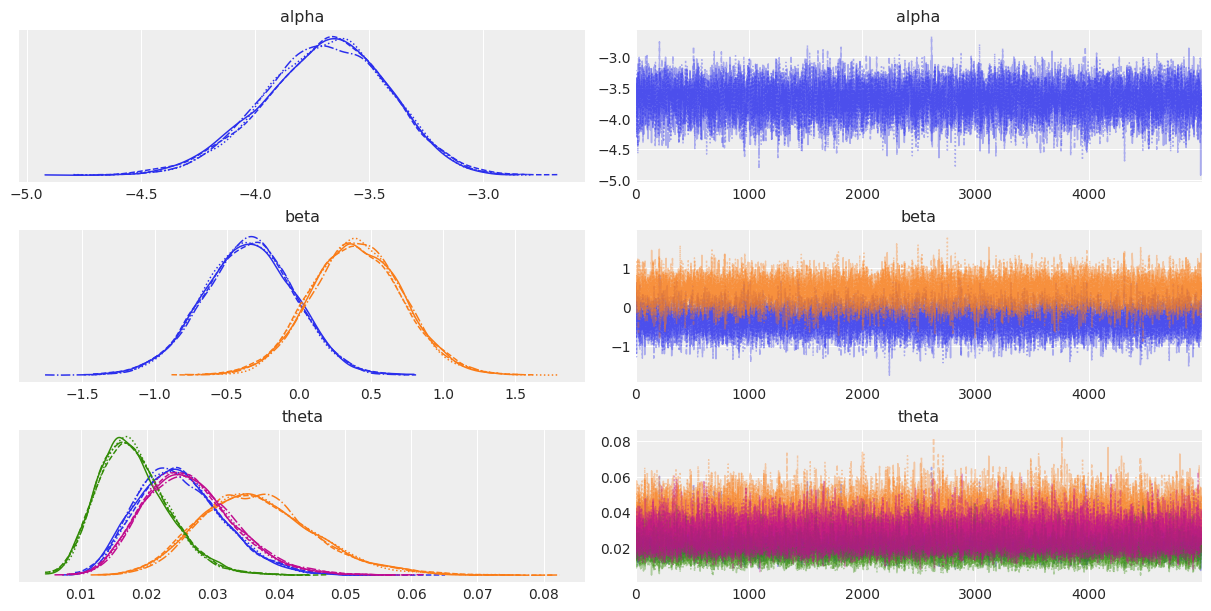

In [14]:
n = [434, 382, 394, 412]
clicks = [8, 17, 10, 8]
img = [0, 0, 1, 1]
btn = [0, 1, 0, 1]

file_path = os.path.join(script_dir, 'model_comb.stan')
model = CmdStanModel(stan_file=file_path)

data = {'N': len(n),'n': n, 'clicks': clicks , 'img': img, 'btn': btn}

fit_comb = model.sample(
  data=data,
  chains=4,
  seed=0,
  iter_warmup=1000,
  iter_sampling=5000,
  show_progress=True
)

cmdstanpy_data_comb = az.from_cmdstanpy(
    posterior=fit_comb,
    log_likelihood="lp__",
)

print(fit_comb.diagnose())
az.plot_trace(cmdstanpy_data_comb.posterior, compact=True) # 事後分布からのサンプルの可視化

In [15]:
beta_samples = fit_comb.stan_variable('beta')

print((beta_samples[:, 1] > 0).mean())

0.89885


交互作用項を追加した統計モデルから得られたサンプルの軌跡

00:09:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:09:39 - cmdstanpy - INFO - CmdStan done processing.



Processing csv files: /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmpgbevb44v/model_int220v00c8/model_int-20230403000939_1.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmpgbevb44v/model_int220v00c8/model_int-20230403000939_2.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmpgbevb44v/model_int220v00c8/model_int-20230403000939_3.csv, /var/folders/nr/8kygzlbx7djc1yh15qnzhhgr0000gn/T/tmpgbevb44v/model_int220v00c8/model_int-20230403000939_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

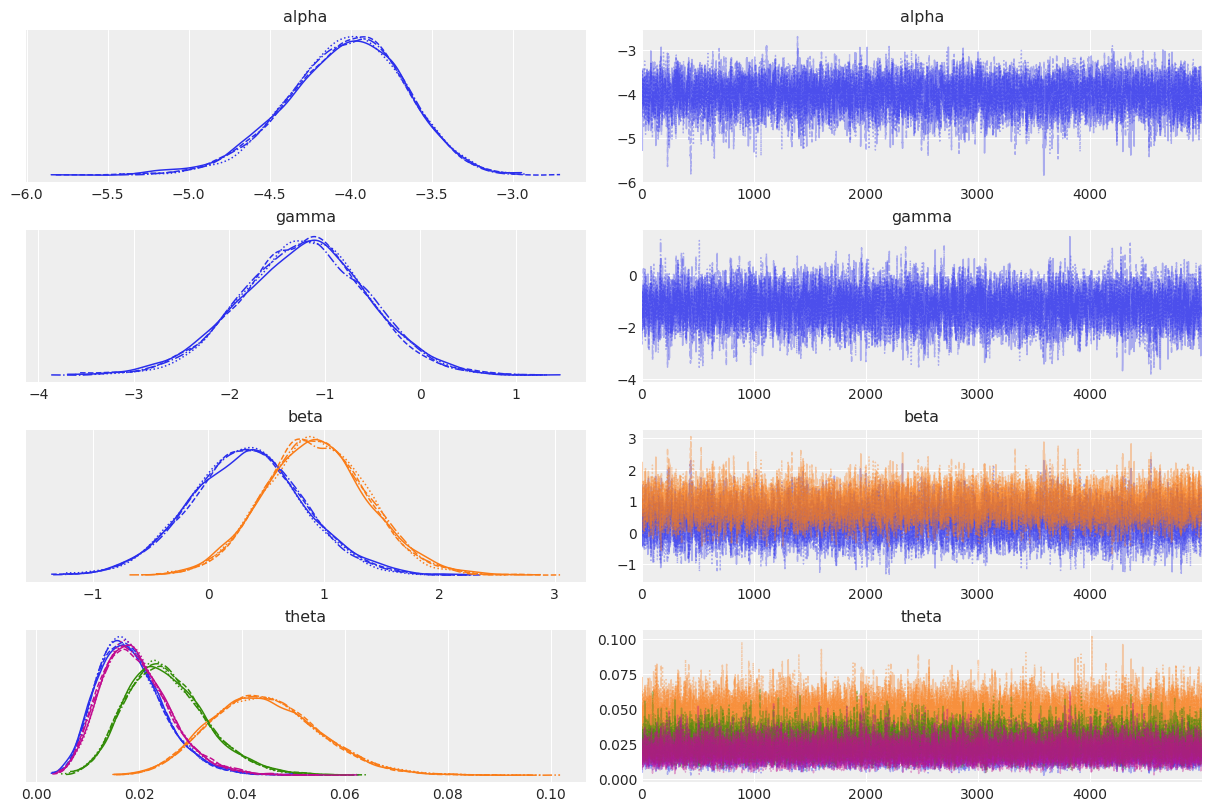

In [16]:
file_path = os.path.join(script_dir, 'model_int.stan')
model = CmdStanModel(stan_file=file_path)

data = {'N': len(n),'n': n, 'clicks': clicks , 'img': img, 'btn': btn}

fit = model.sample(
  data=data,
  chains=4,
  seed=0,
  iter_warmup=1000,
  iter_sampling=5000,
  show_progress=True
)

cmdstanpy_data_int = az.from_cmdstanpy(
    posterior=fit,
    log_likelihood="lp__",
)

print(fit.diagnose())
az.plot_trace(cmdstanpy_data_int.posterior, compact=True) # 事後分布からのサンプルの可視化

In [17]:
gamma_samples = fit.stan_variable('gamma')

print((gamma_samples < 0).mean())

0.96875


In [18]:
beta_samples = fit.stan_variable('beta')

print((beta_samples[:, 0] > 0).mean())
print((beta_samples[:, 1] > 0).mean())

0.75435
0.98565


## モデル選択

主効果のみのモデルCombinedの可視化

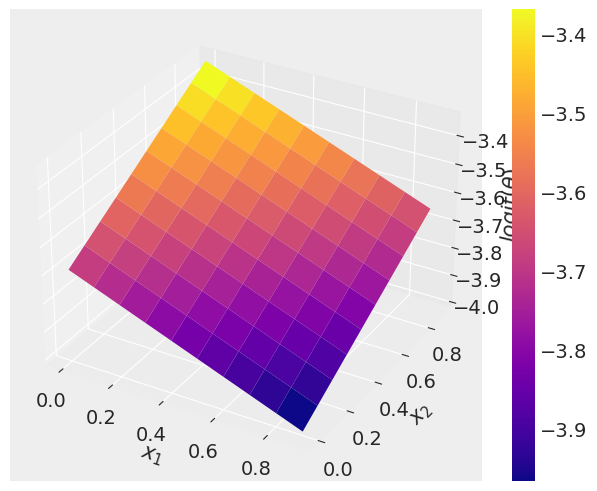

In [19]:
alpha_samples_comb = fit_comb.stan_variable('alpha')
beta_samples_comb = fit_comb.stan_variable('beta')
x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)
logit_theta = (alpha_samples_comb.mean() +
      beta_samples_comb[:, 0].mean() * X1 +
      beta_samples_comb[:, 1].mean() * X2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X1, X2, logit_theta, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')

plt.show()

交互作用を含んだモデルInteractionの可視化

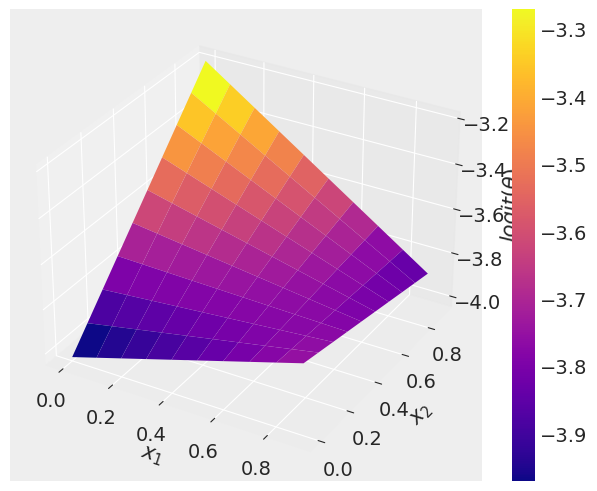

In [20]:
x1 = np.arange(0, 1, 0.1)
x2 = np.arange(0, 1, 0.1)
X1, X2 = np.meshgrid(x1, x2)
alpha_samples = fit.stan_variable('alpha')
beta_samples = fit.stan_variable('beta')
gamma_samples = fit.stan_variable('gamma')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Y = (alpha_samples.mean() +
      beta_samples[:, 0].mean() * X1 +
      beta_samples[:, 1].mean() * X2 +
      gamma_samples.mean() * X1 * X2)
surf = ax.plot_surface(X1, X2, Y, cmap='plasma')
fig.colorbar(surf)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$logit(\theta)$')
plt.show()

In [22]:
#　モデルの推定結果は書籍と同じだが，WAICの値が異なる

waic_comb = az.waic(cmdstanpy_data_comb)
waic_int = az.waic(cmdstanpy_data_int)

az.compare({'int': cmdstanpy_data_int, 'comb': cmdstanpy_data_comb}, ic='waic')

/Users/tueno/.pyenv/versions/3.11.0/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/tueno/.pyenv/versions/3.11.0/lib/python3.11/site-packages/arviz/stats/stats.py:1673: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  warnings.warn(
/Users/tueno/.pyenv/versions/3.11.0/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/tueno/.pyenv/versions/3.11.0/lib/python3.11/site-packages/arviz/stats/stat

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
int,0,-199.035088,2.098415,0.000000,1.0,0.0,0.0,True,log
comb,1,-199.768420,1.485454,0.733332,0.0,0.0,0.0,True,log
